In [1]:
import pandas as pd
import numpy as np

# Hela ML libraries 
from hela import hmm
import hela.generation.hmm as hmm_gen

# Viz libraries
import altair as alt
import hela.visualization.hmm as hmmplot 
import matplotlib.pyplot as plt
from hela.visualization.hmm import TU_COLORS
%matplotlib inline

# Utility Libraries
from datetime import datetime
from dask.distributed import Client
from scipy.special import logsumexp
from scipy import stats
import itertools
from IPython.display import Image

# PGMPy
from hela.hmm.graphical_models import DynamicBayesianNetwork as dbn
from hela.hmm.graphical_models.ContinuousFactor import ContinuousFactor
# from pgmpy.factors.discrete import TabularCPD
import networkx as nx


/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
n = 500
generative_model = hmm_gen.DiscreteHMMGenerativeModel(
                                     n_hidden_states = 2,
                                     n_gaussian_features=0,
                                    n_categorical_features = 2,
                                     n_gmm_components = None)

hidden_states = generative_model.generate_hidden_state_sequence(n_observations = n)
hmm_data = generative_model.generate_observations(hidden_states)
hmm_training_spec = generative_model.generative_model_to_discrete_hmm_training_spec()
model_config = hmm.DiscreteHMMConfiguration.from_spec(hmm_training_spec)
model = model_config.to_model()

In [3]:
from pgmpy.factors.discrete import TabularCPD
# from .DAG import DAG
# Empty Dynamic Bayes Network
graph = dbn.DynamicBayesianNetwork()

# Add latent nodes for t = 0, t = 1
graph.add_nodes_from([('hs', 0), ('hs', 1)], 
                         latent=[True, True])

# Transition edge for hs[t=0] -> hs[t=1]
graph.add_edges_from([(('hs', 0), ('hs', 1))])  

transition_matrix = np.exp(model.log_transition)

transition_cpd = TabularCPD(('hs', 1), model.n_hidden_states, transition_matrix, 
                        evidence=[('hs', 0)], evidence_card=[model.n_hidden_states])

initial_state = np.exp(model.log_initial_state).reshape((len(model.log_initial_state),1))

initial_cpd = TabularCPD(('hs', 0), model.n_hidden_states, initial_state)

graph.add_nodes_from([('cat_obs', 0), ('cat_obs', 1)], latent=[False, False])

emission = np.exp(np.array(model.categorical_model.log_emission_matrix))
emission_card = len(model.categorical_model.finite_values)

graph.add_edges_from([(('hs', 0), ('cat_obs', 0)), (('hs', 1), ('cat_obs', 1))])

categorical_factor0 = TabularCPD(('cat_obs', 0), emission_card, emission, 
                                  evidence=[('hs', 0)], evidence_card=[model.n_hidden_states])

categorical_factor1 = TabularCPD(('cat_obs', 1), emission_card, emission, 
                          evidence=[('hs', 1)], evidence_card=[model.n_hidden_states])

graph.add_factors(transition_cpd, initial_cpd, categorical_factor0, categorical_factor1)


In [4]:
graph.check_model()

True

In [5]:
categorical_dict = {
    str(list(model.categorical_model.finite_values.values[i])): i
    for i in range(len(model.categorical_model.finite_values))
}
categorical_dict

{'[0, 0]': 0, '[0, 1]': 1, '[0, 2]': 2, '[1, 0]': 3, '[1, 1]': 4, '[1, 2]': 5}

In [6]:
hmm_flattened_data = pd.Series(
            [categorical_dict[str(list(v))] for v in np.array(hmm_data)],
            index=hmm_data.index)

In [7]:
ev_keys = [('cat_obs', i) for i in range(n)]

In [8]:
ev_dict = dict(zip(ev_keys, hmm_flattened_data.values[:n]))

In [9]:
variables = [('hs', i) for i in range(2,n)]

In [10]:
from hela.hmm.graphical_models import structured_inference as dbn_inf

inference = dbn_inf.DBNInference(graph)

forward = inference.forward_inference(variables, ev_dict)

Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 102.61it/s]


Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 239.94it/s]


Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 77.96it/s]


Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 223.46it/s]


Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 94.66it/s]


In [11]:
backward = inference.backward_inference(variables, ev_dict)

Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 152.27it/s]


Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 257.48it/s]


Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 138.27it/s]


Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 76.11it/s]


Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 83.45it/s]


Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 82.20it/s]


Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 63.92it/s]


Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 71.42it/s]


Eliminating: ('hs', 0): 100%|██████████| 1/1 [00:00<00:00, 139.92it/s]
/opt/conda/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:788: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi1.values


In [12]:
probabilities = []
for key in forward:
#     print(forward[key])
    print(backward[key])
    probabilities.append(forward[key]*backward[key])

+--------------+------------------+
| ('hs', 2)    |   phi(('hs', 2)) |
+==============+==================+
| ('hs', 2)(0) |           0.0000 |
+--------------+------------------+
| ('hs', 2)(1) |           1.0000 |
+--------------+------------------+
+--------------+------------------+
| ('hs', 3)    |   phi(('hs', 3)) |
+==============+==================+
| ('hs', 3)(0) |           0.0000 |
+--------------+------------------+
| ('hs', 3)(1) |           1.0000 |
+--------------+------------------+
+--------------+------------------+
| ('hs', 4)    |   phi(('hs', 4)) |
+==============+==================+
| ('hs', 4)(0) |           0.0000 |
+--------------+------------------+
| ('hs', 4)(1) |           1.0000 |
+--------------+------------------+
+--------------+------------------+
| ('hs', 5)    |   phi(('hs', 5)) |
+==============+==================+
| ('hs', 5)(0) |           0.0000 |
+--------------+------------------+
| ('hs', 5)(1) |           1.0000 |
+--------------+------------

+----------------+--------------------+
| ('hs', 340)    |   phi(('hs', 340)) |
+================+====================+
| ('hs', 340)(0) |             1.0000 |
+----------------+--------------------+
| ('hs', 340)(1) |             0.0000 |
+----------------+--------------------+
+----------------+--------------------+
| ('hs', 341)    |   phi(('hs', 341)) |
+================+====================+
| ('hs', 341)(0) |             1.0000 |
+----------------+--------------------+
| ('hs', 341)(1) |             0.0000 |
+----------------+--------------------+
+----------------+--------------------+
| ('hs', 342)    |   phi(('hs', 342)) |
+================+====================+
| ('hs', 342)(0) |             1.0000 |
+----------------+--------------------+
| ('hs', 342)(1) |             0.0000 |
+----------------+--------------------+
+----------------+--------------------+
| ('hs', 343)    |   phi(('hs', 343)) |
+================+====================+
| ('hs', 343)(0) |             1.0000 |


+----------------+--------------------+
| ('hs', 495)    |   phi(('hs', 495)) |
+================+====================+
| ('hs', 495)(0) |             0.0000 |
+----------------+--------------------+
| ('hs', 495)(1) |             1.0000 |
+----------------+--------------------+
+----------------+--------------------+
| ('hs', 496)    |   phi(('hs', 496)) |
+================+====================+
| ('hs', 496)(0) |             0.0005 |
+----------------+--------------------+
| ('hs', 496)(1) |             0.9995 |
+----------------+--------------------+
+----------------+--------------------+
| ('hs', 497)    |   phi(('hs', 497)) |
+================+====================+
| ('hs', 497)(0) |             0.0168 |
+----------------+--------------------+
| ('hs', 497)(1) |             0.9832 |
+----------------+--------------------+
+----------------+--------------------+
| ('hs', 498)    |   phi(('hs', 498)) |
+================+====================+
| ('hs', 498)(0) |             0.0014 |


In [13]:
print(backward[key])

+----------------+--------------------+
| ('hs', 499)    |   phi(('hs', 499)) |
+================+====================+
| ('hs', 499)(0) |             0.0014 |
+----------------+--------------------+
| ('hs', 499)(1) |             0.9986 |
+----------------+--------------------+


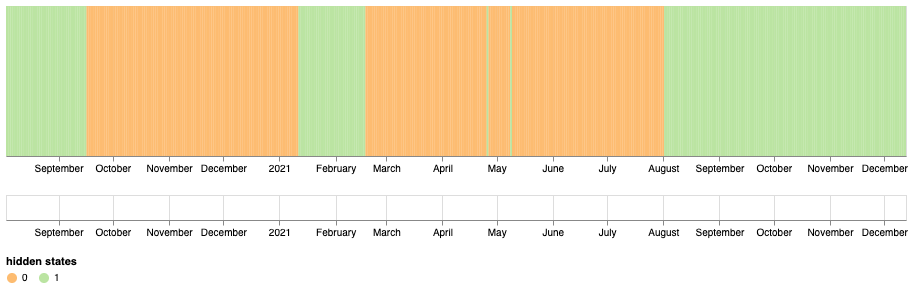

In [14]:
pred_hidden_states = pd.Series(
            [np.argmax(probabilities[i].values) for i in range(len(probabilities))],
            index=hidden_states.index[2:n])
hmmplot.draw_states(pred_hidden_states, hide_brush=False)

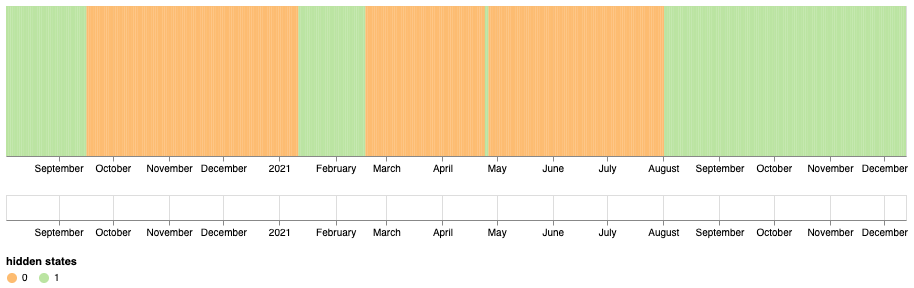

In [15]:
hmmplot.draw_states(hidden_states[2:n], hide_brush=False)